In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
#from keras.models import Sequential
#from keras.layers import Conv1D

In [3]:
# Load data from the pickle file into a DataFrame
with open('/Users/maryam/code/MaryamS-61/phoneme_classification/raw_data/Crema_Spectrogram_8000.pkl', 'rb') as file:
    loaded_df = pickle.load(file)
loaded_df

,Label,FileNames,Spectrograms
0,SAD,1081_ITH_SAD_XX.wav,"[[-50.85168, -37.53515, -48.915, -62.227776, -..."
1,ANG,1081_IEO_ANG_LO.wav,"[[-47.93593, -80.0, -53.17414, -56.48402, -52...."
2,NEU,1079_TSI_NEU_XX.wav,"[[-38.109177, -48.644703, -53.782932, -46.1585..."
3,HAP,1080_IEO_HAP_LO.wav,"[[-59.201244, -68.94307, -51.2046, -48.89463, ..."
4,SAD,1079_IEO_SAD_HI.wav,"[[-40.663616, -47.30068, -43.389248, -35.18830..."
...,...,...,...
7437,HAP,1007_IWL_HAP_XX.wav,"[[-48.35008, -59.10016, -61.12514, -56.870613,..."
7438,DIS,1008_IEO_DIS_LO.wav,"[[-54.37221, -53.520206, -46.53382, -50.349686..."
7439,SAD,1006_TSI_SAD_XX.wav,"[[-31.927896, -34.087387, -80.0, -60.489388, -..."
7440,ANG,1006_TAI_ANG_XX.wav,"[[-48.0942, -51.274445, -70.236664, -59.672203..."


In [4]:
x = loaded_df['Spectrograms']

# Normalizing

In [5]:
original_min = np.min([matrix.min() for matrix in x])
original_max = np.max([matrix.max() for matrix in x])

# Define the new min and max values
new_min = 0
new_max = 1

# Normalize the data to the new range
normalized_x = ((x - original_min) / (original_max - original_min)) * (new_max - new_min) + new_min

In [8]:
normalized_x[0].shape

(1025, 38)

# Zero padding

In [5]:
# Step 1: Find the maximum width
max_width = max(matrix.shape[1] for matrix in normalized_x)

In [6]:
# Step 2: Zero-pad the sequences to the maximum width
zero_padded_matrices = [np.pad(matrix, ((0, 0), (0, max_width - matrix.shape[1])), 'constant') for matrix in normalized_x]


In [7]:
x_normalized_zero_padded = pd.Series(zero_padded_matrices)

In [8]:
x_array_normalized_zero_padded = np.stack(x_normalized_zero_padded)

In [9]:
x_array_normalized_zero_padded.shape

(7442, 1025, 79)

In [10]:
# Define the number of rows and columns to add around the images
pad_rows = 3
pad_cols = 3

# Calculate the new shape of the zero-padded array
new_shape = (
    x_array_normalized_zero_padded.shape[0],
    x_array_normalized_zero_padded.shape[1] + 2 * pad_rows,
    x_array_normalized_zero_padded.shape[2] + 2 * pad_cols
)

# Create a zero-padded array with the new shape
zero_padded_array = np.zeros(new_shape)

# Copy the original array into the center of the zero-padded array
zero_padded_array[:, pad_rows:-pad_rows, pad_cols:-pad_cols] = x_array_normalized_zero_padded

In [11]:
zero_padded_array.shape

(7442, 1031, 85)

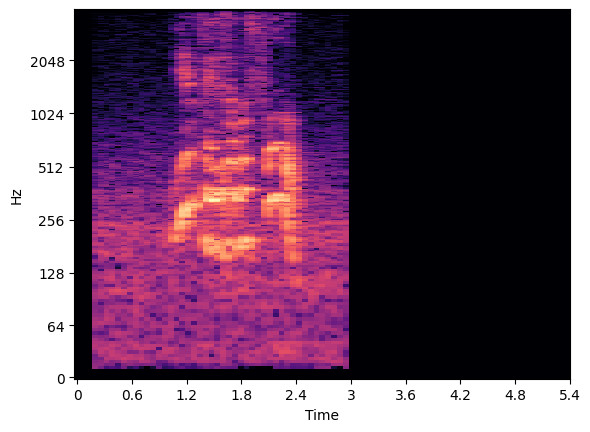

In [12]:
import librosa
librosa.display.specshow(zero_padded_array[1000], sr=8000, x_axis='time', y_axis='log')

In [14]:
loaded_df['SpecInputCNN'] = [matrice for matrice in zero_padded_array]

# Encoding target

In [22]:
from sklearn.preprocessing import OneHotEncoder

# Your training labels as a list of strings
labels = loaded_df['Label'].unique()

# Step 1: Label Encoding (Convert labels to unique integers)
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(loaded_df['Label'])
integer_encoded.shape

# Step 2: One-Hot Encoding (Convert integers to one-hot encoded format)
onehot_encoder = OneHotEncoder(sparse_output=False)
integer_encoded = integer_encoded.reshape(-1, 1)
onehot_encoded_y = onehot_encoder.fit_transform(integer_encoded)

# The 'onehot_encoded' variable now contains one-hot encoded training labels
print(onehot_encoded_y.shape)

(7442, 6)


In [24]:
loaded_df['EncodedLabels'] = [label for label in onehot_encoded_y]

In [28]:
loaded_df

,Label,FileNames,Spectrograms,SpecInputCNN,EncodedLabels
0,SAD,1081_ITH_SAD_XX.wav,"[[-50.85168, -37.53515, -48.915, -62.227776, -...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
1,ANG,1081_IEO_ANG_LO.wav,"[[-47.93593, -80.0, -53.17414, -56.48402, -52....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
2,NEU,1079_TSI_NEU_XX.wav,"[[-38.109177, -48.644703, -53.782932, -46.1585...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
3,HAP,1080_IEO_HAP_LO.wav,"[[-59.201244, -68.94307, -51.2046, -48.89463, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
4,SAD,1079_IEO_SAD_HI.wav,"[[-40.663616, -47.30068, -43.389248, -35.18830...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
...,...,...,...,...,...
7437,HAP,1007_IWL_HAP_XX.wav,"[[-48.35008, -59.10016, -61.12514, -56.870613,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
7438,DIS,1008_IEO_DIS_LO.wav,"[[-54.37221, -53.520206, -46.53382, -50.349686...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
7439,SAD,1006_TSI_SAD_XX.wav,"[[-31.927896, -34.087387, -80.0, -60.489388, -...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
7440,ANG,1006_TAI_ANG_XX.wav,"[[-48.0942, -51.274445, -70.236664, -59.672203...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


In [30]:
loaded_df = loaded_df.drop('Spectrograms', axis=1)

In [32]:
with open('Crema_spec_cnn_input.pkl', 'wb') as file:
    pickle.dump(loaded_df, file)
